# Initial analysis of the stereofog dataset

In [29]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from general_imports import *
import matplotlib
from matplotlib import cm   # colormap for the rating of the fogginess
from utils_stereofog import variance_of_laplacian

import cv2

In [3]:
dataset_path = 'datasets/stereofog_images'

## Calculating the Variance of the Laplacian for all images in the dataset

In [4]:
variance_values = []
image_count = 0
subfolder = 'B'

for folder in [item for item in os.listdir(dataset_path) if item[0] != '.' and '.xlsx' not in item]:
    
    for image in [item for item in os.listdir(os.path.join(dataset_path, folder, subfolder)) if item[0] != '.']:

        image_count += 1
        image_path = os.path.join(dataset_path, folder, subfolder, image)
        image_gray = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
        variance_values.append(-variance_of_laplacian(image_gray))

print('Total images: {}'.format(image_count))
print('Mean variance: {}'.format(sum(variance_values) / len(variance_values)))

Total images: 7274
Mean variance: 20.493986244086287


In [5]:
variance_values_df = pd.Series(sorted(variance_values))

## Treating the distribution with the Interguartile Rule

In [10]:
Q1 = np.percentile(variance_values_df, 25, method='midpoint')
Q3 = np.percentile(variance_values_df, 75, method='midpoint')
IQR = Q3 - Q1

upper=Q3+1.5*IQR
lower=Q1-1.5*IQR

## Plotting the cropped distribution

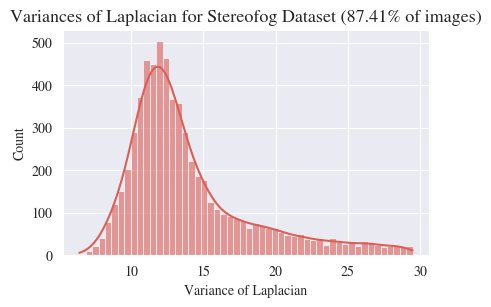

In [20]:
fig, ax = plt.subplots(figsize=set_size())

sns.histplot(variance_values_df[(variance_values_df < upper) & (variance_values_df > lower)], ax = ax, kde=True, fill=True, alpha=0.6)
ax.set_xlabel('Variance of Laplacian')
ax.set_ylabel('Count')

plt.savefig('plots/stereofog_dataset_variances.pdf', format='pdf', bbox_inches='tight')

ax.set_title(f'Variances of Laplacian for Stereofog Dataset ({len(variance_values_df[(variance_values_df < upper) & (variance_values_df > lower)]) / len(variance_values_df)*100:.2f}% of images)')
plt.show()

## Plotting example images for low, medium and high fog

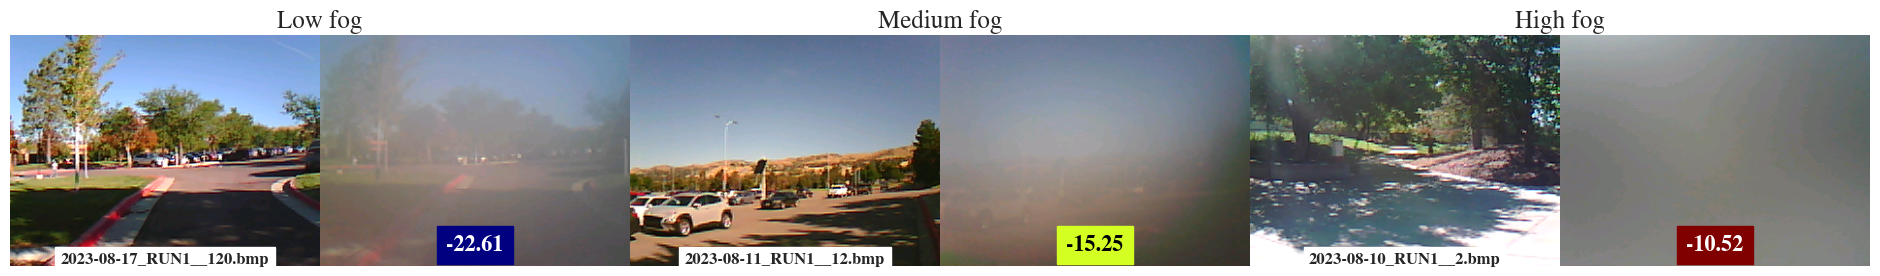

In [40]:
ratio = 4 / 3

width_per_image = 4
height_per_image = width_per_image / ratio

num_images = 6
fig = plt.figure(figsize=(num_images*width_per_image, height_per_image))

ax = [fig.add_subplot(1,num_images,i+1) for i in range(num_images)]

images =    [   '2023-08-17_RUN1__120.bmp', # low fog example
                '2023-08-11_RUN1__12.bmp', # medium fog example
                '2023-08-10_RUN1__2.bmp' # high fog example
            ]

dataset_path = '../stereofog_images'

variances = [] # list of variances of Laplacian for each image

for index, image in enumerate(images):

    parent_folder = image.replace('__', '/').split('/')[0]
    img_A_path = os.path.join(dataset_path, parent_folder, 'A', image)
    img_B_path = os.path.join(dataset_path, parent_folder, 'B', image)

    img_A = plt.imread(img_A_path)
    img_B = plt.imread(img_B_path)

    ax[index*2].imshow(img_A, aspect='auto')
    ax[index*2].axis('off')
    ax[index*2+1].imshow(img_B, aspect='auto')
    ax[index*2+1].axis('off')

    ax[index*2].text(0.5, 0, image, horizontalalignment='center', verticalalignment='bottom', transform=ax[index*2].transAxes, fontweight='bold', fontsize=12, backgroundcolor='white')

    # Calculating the variance of Laplacian of the fogged image and adding it to the plot
    img_B_gray = cv2.cvtColor(img_B, cv2.COLOR_BGR2GRAY)
    variances += [variance_of_laplacian(img_B_gray)]
    
norm = matplotlib.colors.Normalize(vmin=min(variances), vmax=max(variances))    # Normalizer for the values of the colormap rating the fogginess of the image: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib


for index in range(num_images//2):
    ax[index*2+1].text(0.5, 0.045, f'{variances[index]:.2f}', horizontalalignment='center', verticalalignment='bottom', transform=ax[index*2+1].transAxes, fontweight='bold', backgroundcolor=cm.jet(norm(variances[index])), fontsize=16, color='black' if index == 1 else 'white')

ax[0].text(1., 1.06, 'Low fog', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=18)
ax[2].text(1., 1.06, 'Medium fog', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=18)
ax[4].text(1., 1.06, 'High fog', horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes, fontsize=18)

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('plots/stereofog_dataset_examples.pdf', format='pdf', bbox_inches='tight')
plt.show()